In [10]:
import scvelo as scv
import numpy as np  
import matplotlib.pyplot as plt

import anndata

import sys
sys.path.append("..")


import cellpath as cp
import cellpath.visual as visual
import cellpath.benchmark as bmk 
import cellpath.de_analy as de


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import seaborn as sns

import scprep
import pandas as pd

## Meta-cell construction

In [74]:
# read in simulated dataset
adata = anndata.read_h5ad("../sim_data/Symsim/multi_cycles_200_rand1_clust.h5ad")

In [3]:
adata.layers["spliced"].todense()

matrix([[1.20430592e-01, 2.50409407e+00, 5.30010791e+00, ...,
         8.33922512e+01, 1.46905947e+02, 6.41822262e-02],
        [1.20430592e-01, 3.17618970e+00, 4.38708374e+00, ...,
         8.33098925e+01, 1.46944799e+02, 8.89853677e-02],
        [3.46303361e-02, 1.62355566e+00, 6.31938287e+00, ...,
         7.90884985e+01, 1.47427121e+02, 2.78461377e-02],
        ...,
        [2.17772467e-01, 1.34488676e+00, 2.73466122e+00, ...,
         6.13558501e+01, 1.48739117e+02, 5.09269478e-13],
        [8.90265524e-02, 1.32724751e+00, 3.37279873e+00, ...,
         6.05543937e+01, 1.52790715e+02, 3.07354019e-13],
        [8.90265524e-02, 1.29456034e+00, 3.53985381e+00, ...,
         6.04368637e+01, 1.53237763e+02, 2.80384518e-13]])

In [45]:
cellpath_obj = cp.CellPath(adata = adata)
# self, n_clusters = None, include_unspliced = True, standardize = True, **kwarg
cellpath_obj.meta_cell_construction(n_clusters = 100, include_unspliced = True, standardize = True)
cellpath_obj.meta_cell_graph(k_neighs = 5, pruning = False, scaling = 4, distance_scalar = 0.5)
cellpath_obj.meta_paths_finding(threshold = 0.5, cutoff_length = None, length_bias = 0.5, max_trajs = 30)
cellpath_obj.first_order_pt(num_trajs = None, insertion = True, prop_insert = 0.0)

Already conducted clustering
Meta-cell constructed, number of meta-cells: 100
Meta-cell level neighborhood graph constructed
conduct quality control
selected path (starting_ending):
start_end:  13_62 , len:  57 newly covered: 57
start_end:  29_87 , len:  45 newly covered: 10
start_end:  34_92 , len:  56 newly covered: 2
start_end:  64_62 , len:  57 newly covered: 1
Finished
number of cells: 0
Cell-level pseudo-time inferred


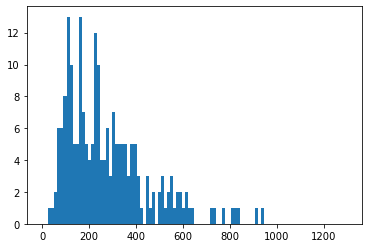

In [46]:
visual.weight_histogram(cellpath_obj, resolution = 100)

In [68]:
def plot_data(cellpath_obj, basis = "umap", figsize = (15,7), save_as = None, title = None, **kwargs):

    _kwargs = {
        "axis": False,
        "legend_pos": "upper left",
        "colormap": "tab20",
        "s": 10,
        "add_arrow": False,
        "markerscale": 1.0
    }
    _kwargs.update(kwargs)

    X = cellpath_obj.adata.obsm["X_" + basis]
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    if _kwargs["axis"]:
        ax.tick_params(axis = "both", direction = "out", labelsize = 16)
        ax.set_xlabel("PC1", fontsize = 19)
        ax.set_ylabel("PC2", fontsize = 19)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    else:
        ax.axis("off")

    if "clusters" in cellpath_obj.adata.obs.columns:
        cluster_anno = [x for x in cellpath_obj.adata.obs["clusters"].values]
        cluster_uni = [x for x in np.unique(cellpath_obj.adata.obs["clusters"].values)]

        colormap = plt.cm.get_cmap(_kwargs["colormap"], len(cluster_uni))

        for count, clust in enumerate(cluster_uni):
            idx = np.where(np.array(cluster_anno) == clust)[0]
            ax.scatter(X[idx,0], X[idx,1], color = colormap(count), alpha = 0.7, label = clust, s = _kwargs["s"])    
        ax.legend(loc=_kwargs["legend_pos"], prop={'size': 20}, frameon = False, ncol = 1, markerscale=_kwargs["markerscale"])
    
    elif "sim_time" in cellpath_obj.adata.obs.columns:
        X_ordered = X[np.argsort(cellpath_obj.adata.obs["sim_time"].values),:]
        if _kwargs["add_arrow"]:
            for i in range(X_ordered.shape[0]-1):
                line = ax.plot(X_ordered[i:(i+2), 0], X_ordered[i:(i+2), 1], 'gray', '-', alpha = 1)
                visual.add_arrow(line[0], size = 5)

        pic = ax.scatter(X_ordered[:,0], X_ordered[:,1], cmap = "gnuplot", c = np.arange(X_ordered.shape[0]), alpha = 1, s = _kwargs["s"])
        cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
        cbar.ax.tick_params(labelsize = 20)
        

    else:
        ax.scatter(X[:,0], X[:,1], color = "red", alpha = 0.7, s = _kwargs["s"])

    if title is not None:
        ax.set_title(title, fontsize = 25)
    if save_as != None:
        fig.savefig(save_as, bbox_inches = 'tight')



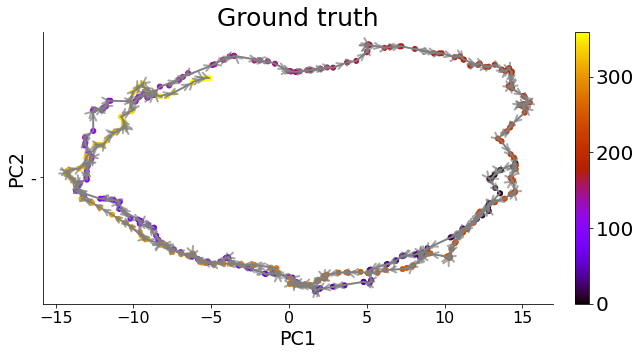

In [69]:
plot_data(cellpath_obj, basis = "pca", figsize = (10,5), save_as = "multicycle.png", add_arrow = True, s = 25, axis = True, title = "Ground truth")

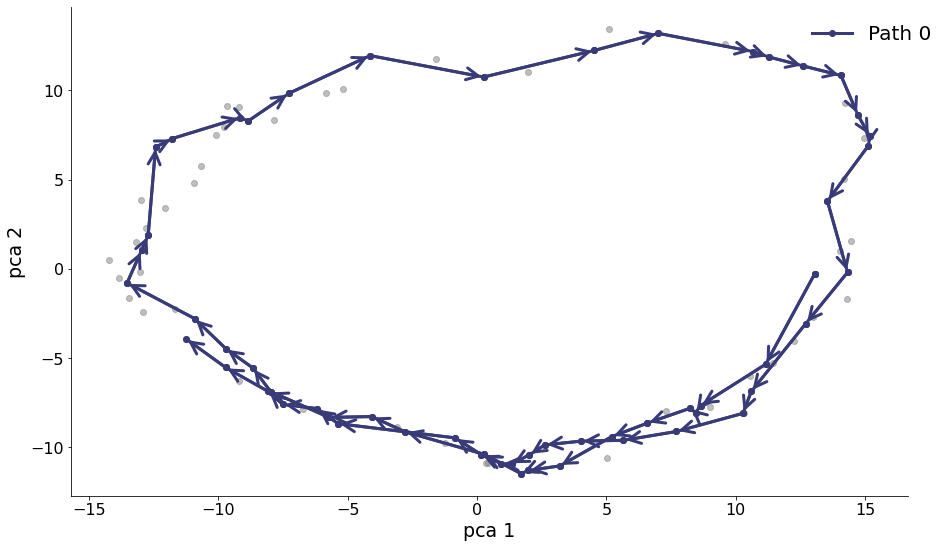

In [48]:
visual.meta_traj_visual(cellpath_obj, basis = "pca", trajs = 1, figsize = (15,9), save_as = None, axis = True)

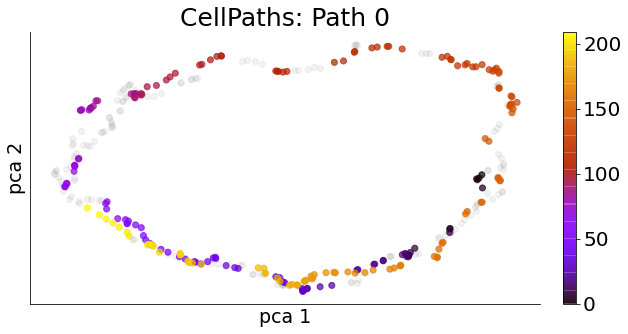

In [49]:
visual.first_order_approx_pt(cellpath_obj, basis = "pca", trajs = 1, figsize= (10,5), save_as = None)

# Benchmark
## Kendall-tau test

(360, 600)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Meta-cell constructed, number of meta-cells: 100
Meta-cell level neighborhood graph constructed
cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  91_46 , len:  60 newly covered: 60
start_end:  36_51 , len:  58 newly covered: 3
start_end:  58_46 , len:  59 newly covered: 1
Finished
number of cells: 126
Cell-level pseudo-time inferred


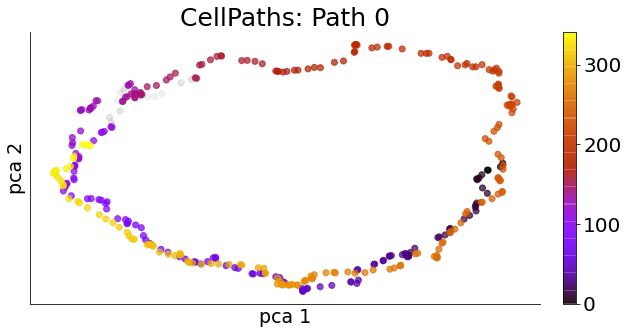

R[write to console]: Using full covariance matrix


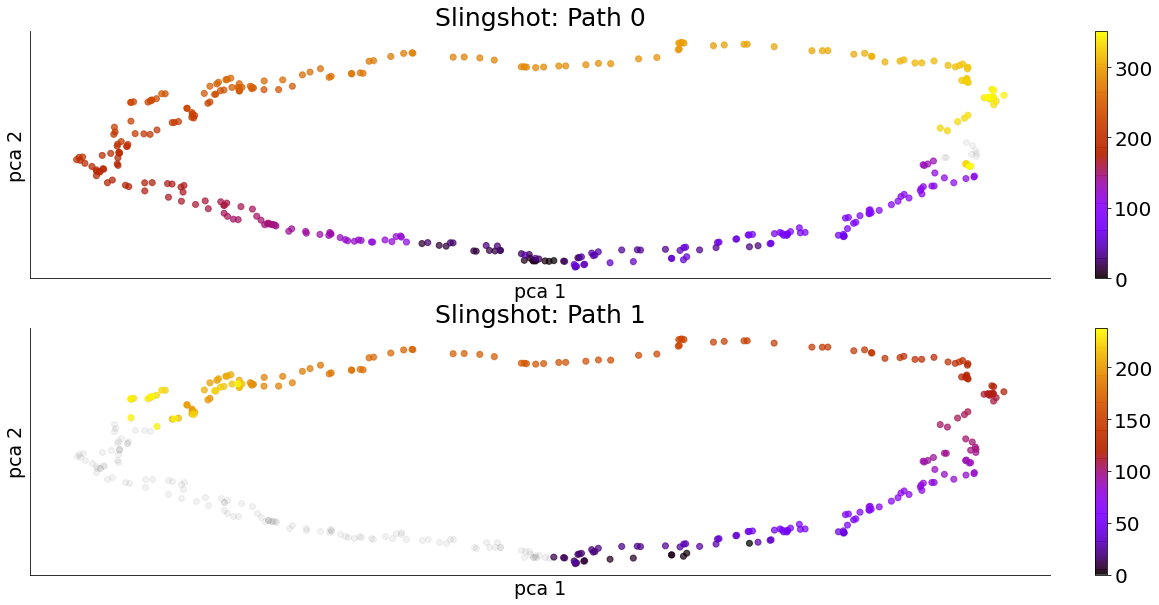

(360, 600)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Meta-cell constructed, number of meta-cells: 100
Meta-cell level neighborhood graph constructed
cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  14_23 , len:  56 newly covered: 55
start_end:  92_34 , len:  46 newly covered: 9
start_end:  14_51 , len:  55 newly covered: 1
start_end:  14_86 , len:  55 newly covered: 1
start_end:  83_23 , len:  54 newly covered: 1
Finished
number of cells: 143
Cell-level pseudo-time inferred


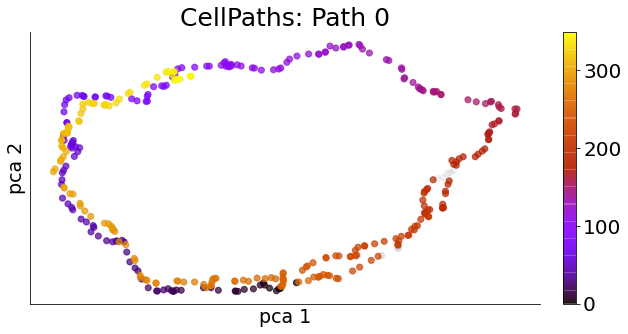

R[write to console]: Using full covariance matrix


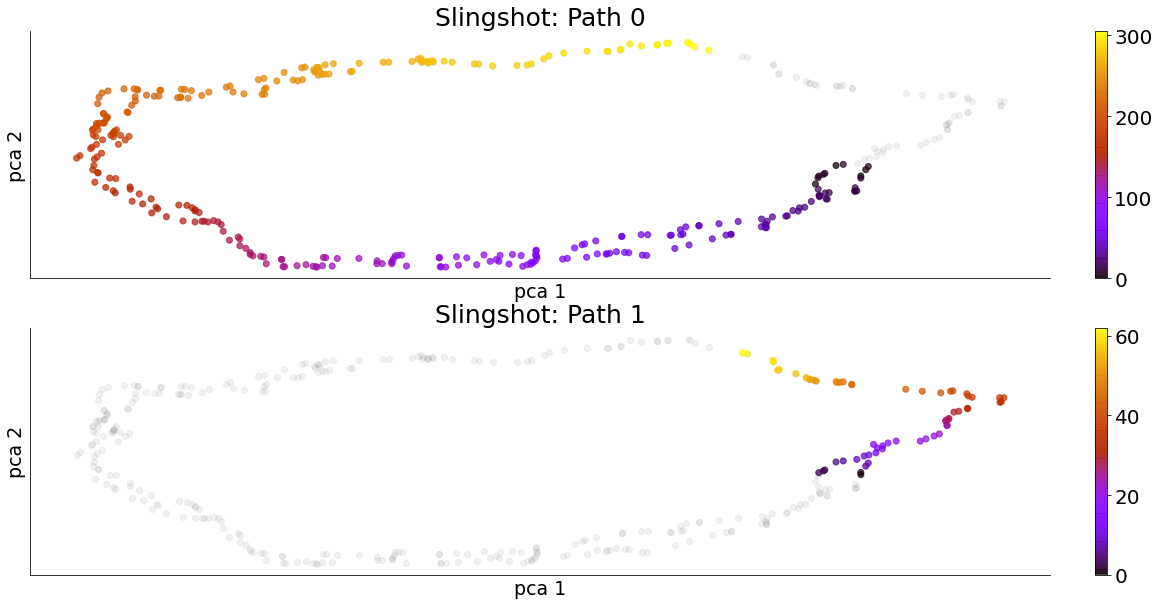

(360, 600)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Meta-cell constructed, number of meta-cells: 100
Meta-cell level neighborhood graph constructed
cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  55_96 , len:  60 newly covered: 60
start_end:  66_15 , len:  50 newly covered: 8
Finished
number of cells: 104
Cell-level pseudo-time inferred


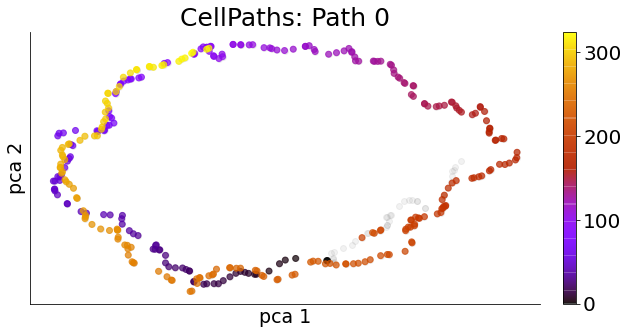

R[write to console]: Using full covariance matrix


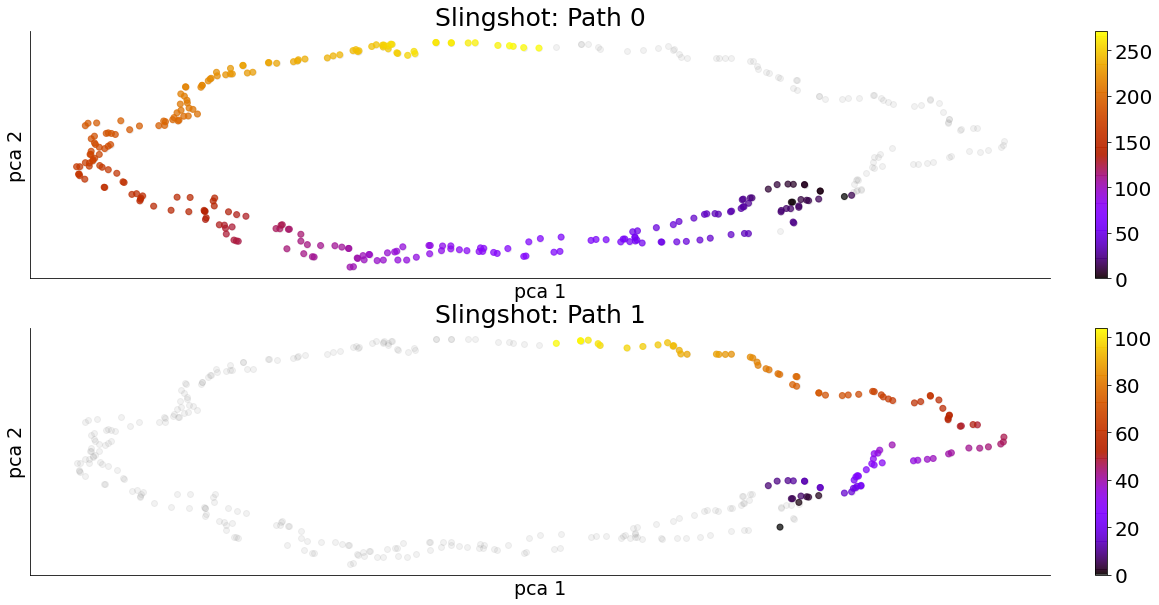

(360, 600)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Meta-cell constructed, number of meta-cells: 100
Meta-cell level neighborhood graph constructed
cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  91_43 , len:  52 newly covered: 52
start_end:  88_65 , len:  49 newly covered: 15
start_end:  38_8 , len:  49 newly covered: 4
start_end:  7_81 , len:  49 newly covered: 3
start_end:  13_43 , len:  50 newly covered: 2
Finished
number of cells: 121
Cell-level pseudo-time inferred


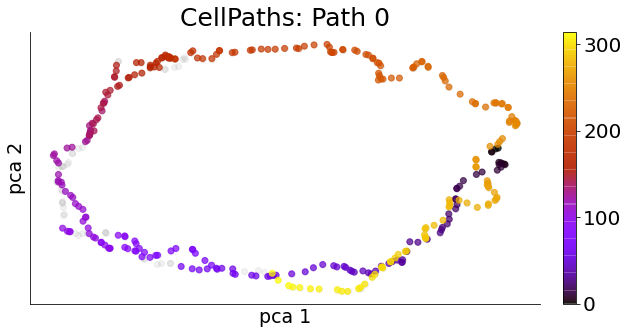

R[write to console]: Using full covariance matrix


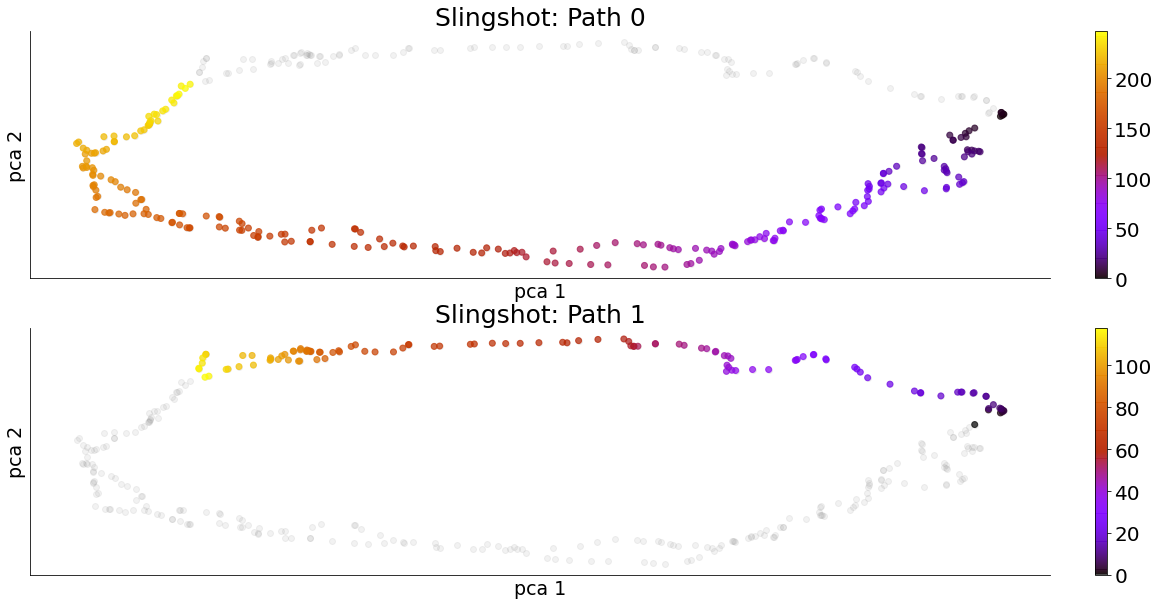

(360, 600)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
Meta-cell constructed, number of meta-cells: 100
Meta-cell level neighborhood graph constructed
cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  46_0 , len:  71 newly covered: 71
start_end:  90_62 , len:  70 newly covered: 2
Finished
number of cells: 104
Cell-level pseudo-time inferred


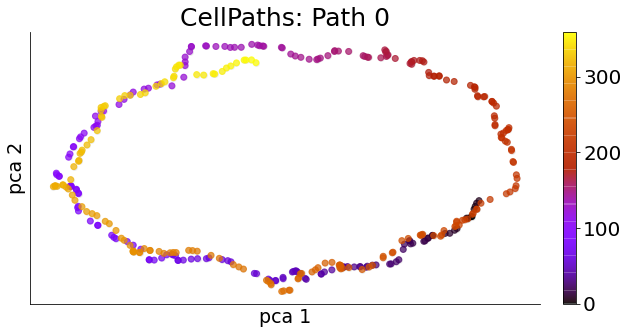

R[write to console]: Using full covariance matrix


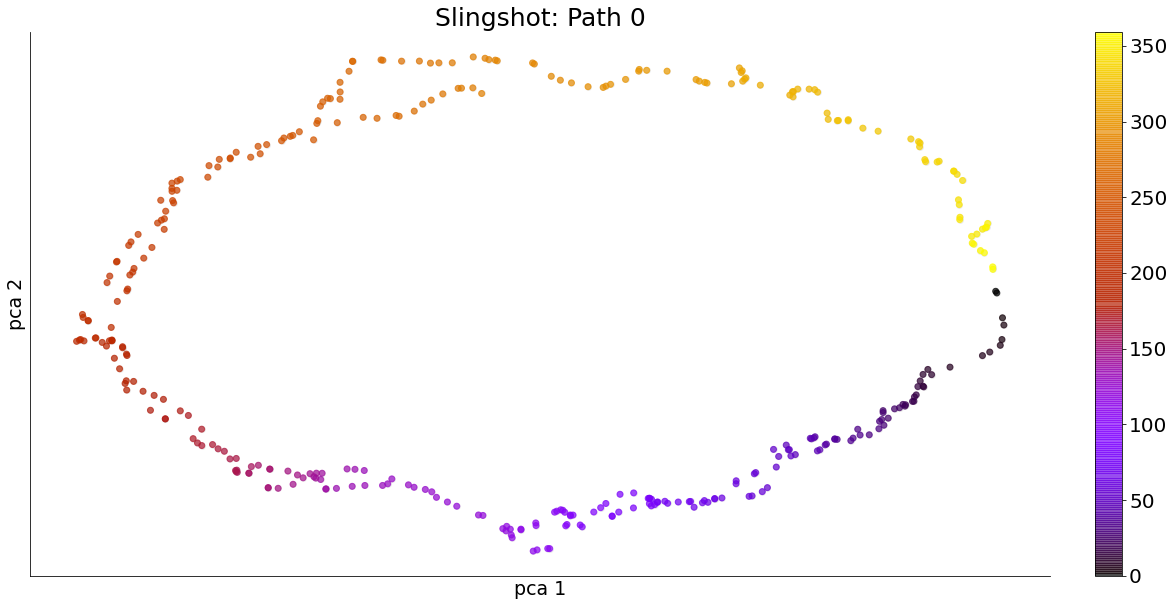

In [77]:
num_metacells = 100
num_trajs = 1
kt_dpt = []
kt_cellpath = []
kt_slingshot = []

path = "../results/sim/multi-cycles/"

for i in range(1,6):
    adata = anndata.read_h5ad("../sim_data/Symsim/multi_cycles_200_rand" + str(i) + ".h5ad")
    print(adata.shape)
    pt_true = adata.obs["sim_time"].values
    
    scv.tl.velocity_pseudotime(adata)
    pt_vdpt = adata.obs['velocity_pseudotime'].values
    kt_dpt.extend([bmk.kendalltau(pt_vdpt, pt_true)])

    cellpath_obj = cp.CellPath(adata = adata, preprocess = True)
    # here we use fast implementation, the flavor can also be changed to "k-means" for k-means clustering
    cellpath_obj.all_in_one(flavor = "k-means", num_metacells = num_metacells, resolution = None, n_neighs = 5, num_trajs = num_trajs, insertion = True, prop_insert = 0.30, seed = 0, mode = "exact", pruning = False, scaling = 4, distance_scalar = 0.5)
    visual.first_order_approx_pt(cellpath_obj, basis="pca", trajs = num_trajs, figsize=(10,5), save_as= path + "cellpath_"+ str(i)+".png")
    kt_cellpath.extend([x for x in bmk.cellpath_kt(cellpath_obj).values()])

    kmeans = KMeans(n_clusters = 10, init = "k-means++", n_init = 10, max_iter = 300, tol = 0.0001, random_state = 0)
    groups = kmeans.fit_predict(adata.obsm["X_pca"])
    meta_data = adata.obs
    meta_data['groups'] = groups
    results = scprep.run.Slingshot(pd.DataFrame(index=[str(x) for x in range(adata.shape[0])], columns= np.arange(2), data = adata.obsm["X_pca"][:,0:2]), meta_data['groups'], start_cluster = groups[0])
    kts = visual.slingshot_visual(adata, results, basis = "pca", figsize=(20,10), save_as = path + "slingshot_"+ str(i)+".png")
    kt_slingshot.extend([x for x in kts.values()])


In [42]:
kt_reCAT =[]
for rand in range(1,6):
    pt_infer = pd.read_csv("../sim_data/reCAT/pt_200cells_rand"+str(rand)+".csv", index_col = 0, sep = "\t").values.squeeze()
    adata = anndata.read_h5ad("../sim_data/Symsim/multi_cycles_200_rand" + str(rand) + ".h5ad")
    pt_true = adata.obs["sim_time"].values.squeeze()
    kt = bmk.kendalltau(pt_infer[200:], pt_true[200:])
    kt_reCAT.append(kt)

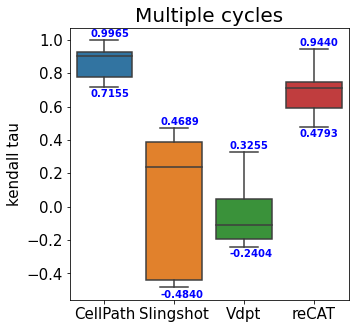

In [43]:
kts_array = [kt_cellpath, kt_slingshot, kt_dpt, kt_reCAT]

max_kts = [max(x) for x in kts_array]
min_kts = [min(x) for x in kts_array]
# my_formatted_list = [ '%.2f' % elem for elem in my_list ]
max_kts_text = ['%.4f' % x for x in max_kts]
min_kts_text = ['%.4f' % x for x in min_kts]

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
bp = sns.boxplot(data = kts_array, ax = ax)#, x = ["CellPaths", "slingshot", "vdpt"])
ax.set_xticklabels(["CellPath", "Slingshot", "Vdpt", "reCAT"],fontsize = 15)
ax.set_ylabel("kendall tau", fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_title("Multiple cycles", fontsize = 20)
for xtick in bp.get_xticks():
    bp.text(xtick - 0.2, max_kts[xtick]+ 0.02, max_kts_text[xtick], size='medium',color = "b", weight='semibold')
    bp.text(xtick - 0.2, min_kts[xtick]- 0.06, min_kts_text[xtick], size='medium',color = "b", weight='semibold')
fig.savefig("../results/sim/multi-cycles/boxplot.png", bbox_inches = "tight")


### CellPaths

In [51]:
X_pca = adata.obsm['X_pca']

n_clusters = 10
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol, random_state = 0)
groups = kmeans.fit_predict(X_pca)
meta_data = adata.obs
meta_data['groups'] = groups

Text(0.5, 1.0, 'slingshot clusters')

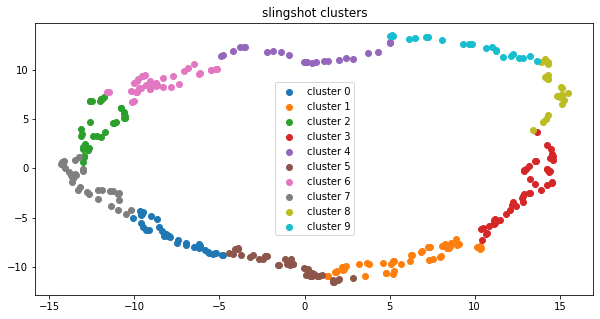

In [52]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()
c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))
    # progression = ax.scatter(X_umap[sub_cells,0], X_umap[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")
# fig.savefig("./syn_results/dataset1/slingshot_clust.pdf")

In [53]:
import pandas as pd
import scprep
X_pca_df = pd.DataFrame(index=[str(x) for x in range(X_pca.shape[0])], columns= np.arange(2), data = X_pca[:,0:2])
# scprep.run.install_bioconductor('slingshot')
results = scprep.run.Slingshot(pd.DataFrame(index=[str(x) for x in range(adata.shape[0])], columns= np.arange(2), data = adata.obsm["X_pca"][:,0:2]), meta_data['groups'], start_cluster = groups[0])

R[write to console]: Using full covariance matrix


In [62]:
import importlib 
importlib.reload(visual)

<module 'cellpath.visual' from '../cellpath/visual.py'>

In [72]:

def slingshot_visual(adata, results, basis = "umap", figsize = (20,10), save_as = None, title = None, axis = True, use_pcurve = False):
 
    if "X_" + basis not in adata.obsm:
        raise ValueError("please calculate " + basis + " first")
    else:
        X = adata.obsm['X_' + basis]

    trajs = results['pseudotime'].shape[1]
    nrows = np.ceil(trajs).astype('int32')
    ncols = 1
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    if title:
        fig.suptitle("Slingshot pseudo-time", fontsize = 18)

    kt = {}

    for i in range(trajs):
        if nrows == 1 or ncols == 1:
            if nrows == 1 and ncols == 1:
                ax = axs
            else:
                ax = axs[i]
        else:
            ax = axs[i%nrows, i//nrows]

        ax.scatter(X[:,0],X[:,1], color = 'gray', alpha = 0.1)
        if use_pcurve:
            ax.plot(results['curves'][i,:,0],results['curves'][i,:,1],color = 'black', linewidth = 4)

        # kendall-tau
        pt_i = results['pseudotime'].iloc[:,i]
        pt_index = [x for x in pt_i.index if not np.isnan(pt_i[x])]
        ordering = [eval(x) for x in pt_i[pt_index].sort_values().index]
        pt_i = pt_i[pt_index]
        true_i = adata.obs['sim_time'].iloc[pt_index].values
        kt["traj_"+str(i)] = bmk.kendalltau(pt_i, true_i)

        X_traj = X[ordering,:]

        pseudo_visual = ax.scatter(X_traj[:,0],X_traj[:,1],c = np.arange(X_traj.shape[0]), cmap=plt.get_cmap('gnuplot'),alpha = 0.7)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("PC1", fontsize = 19)
        ax.set_ylabel("PC2", fontsize = 19)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        cbar = fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax)
        cbar.ax.tick_params(labelsize = 20)
        ax.set_title("Slingshot: Path " + str(i), fontsize = 25)

    if save_as != None:
        fig.savefig(save_as,bbox_inches = 'tight')
    plt.show()    
    return kt



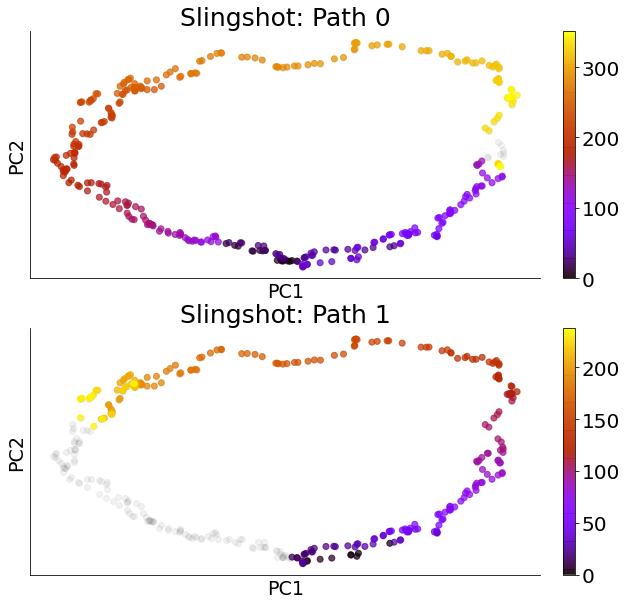

In [73]:
kt_slingshot = slingshot_visual(adata,  results, basis= "pca", figsize=(10,10), save_as = "slingshot.png", use_pcurve = False)

# velocity DPT

In [58]:
# adata = anndata.read_h5ad("../sim_data/Symsim/multi_cycles_200_rand5.h5ad")
scv.tl.velocity_pseudotime(adata)

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


Text(0.5, 1.0, 'Vdpt')

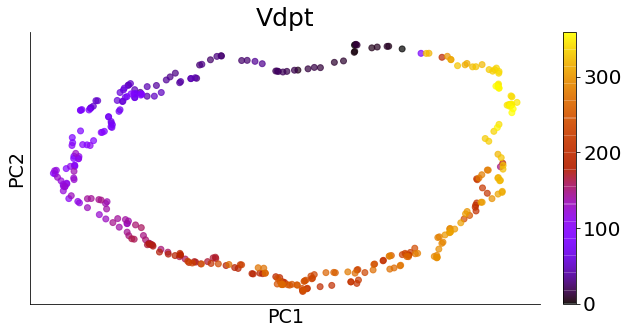

In [60]:
X_pca = adata.obsm["X_pca"]
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()

# for i in range(X_pca.shape[0]-1):
#     line = ax.plot(X_pca[i:(i+2), 0], X_pca[i:(i+2), 1], 'gray', '-', alpha = 1)
#     visual.add_arrow(line[0], size = 10)

pic = ax.scatter(X_pca[np.argsort(y_vdpt),0],X_pca[np.argsort(y_vdpt),1], alpha = 0.7, cmap = 'gnuplot', c = np.arange(X_pca.shape[0]))
ax.tick_params(axis = "both", direction = "out", labelsize = 16)
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)
ax.set_title("Vdpt", fontsize = 25)

# fig.savefig("Vdpt.png", bbox_inches = "tight")

## scvelo Latent times

In [22]:
adata = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_200_rand5.h5ad")
scv.tl.recover_dynamics(adata)
# or recover_latent_time, the functionality is the same
scv.tl.latent_time(adata)
lt = adata.obs["latent_time"].values

recovering dynamics
    finished (0:01:16) --&gt; added 
    &#39;fit_pars&#39;, fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00) --&gt; added
    &#39;root_cells&#39;, root cells of Markov diffusion process (adata.obs)
    &#39;end_points&#39;, end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:00) --&gt; added 
    &#39;latent_time&#39;, shared time (adata.obs)


In [25]:
adata2 = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_200_rand5.h5ad")
scv.tl.recover_dynamics(adata2)
scv.tl.recover_latent_time(adata2)

recovering dynamics
    finished (0:01:15) --&gt; added 
    &#39;fit_pars&#39;, fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00) --&gt; added
    &#39;root_cells&#39;, root cells of Markov diffusion process (adata.obs)
    &#39;end_points&#39;, end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:00) --&gt; added 
    &#39;latent_time&#39;, shared time (adata.obs)


Text(0.5, 1.0, &#39;velocity diffusion pseudo-time: Path 0&#39;)

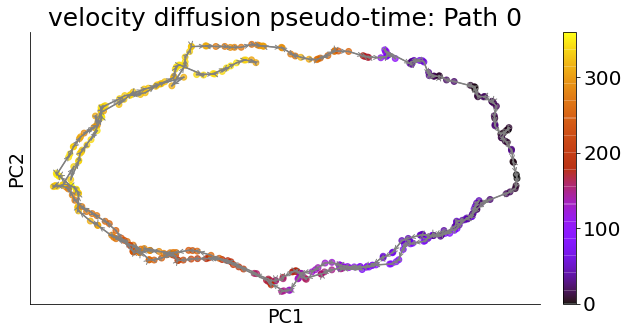

In [23]:
# X_pca = adata.obsm["X_pca"]
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()

for i in range(X_pca.shape[0]-1):
    line = ax.plot(X_pca[i:(i+2), 0], X_pca[i:(i+2), 1], 'gray', '-', alpha = 1)
    visual.add_arrow(line[0], size = 10)

pic = ax.scatter(X_pca[:,0],X_pca[:,1], alpha = 0.7, cmap = 'gnuplot', c = lt * X_pca.shape[0])
ax.tick_params(axis = "both", direction = "out", labelsize = 16)
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)
ax.set_title("velocity diffusion pseudo-time: Path " + str(0), fontsize = 25)

# fig.savefig("./sim_results/Symsim/multiple_cycles/400/vdpt.pdf", bbox_inches = "tight")